# Notebook to produce camera ready plots for Cardinality Estimation Paper

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import json

import random
from matplotlib import ticker
import math

import matplotlib as mpl
from cycler import cycler

In [113]:
#which methods to plot
#methods = ['GNCE', 'LMKG', 'wj', 'impr', 'jsub', 'cset']
methods = ['GNCE', 'LMKG', 'lss', 'wj', 'impr', 'jsub', 'cset']
methods_labels = ['GNCE', 'LMKG', 'LSS', 'Wanderjoin', 'impr', 'jsub', 'CSET']

In [144]:
# The dataset to plot for 
dataset = "yago_inductive"
# The query type
query_type = "star"
# Optional, currently not used
tag = ""

# Whether to exclude all predictions with value >= 0
exclude_invalid = False

In [145]:
exclude_1_tp_queries = False

In [146]:
# Flag whether to save the plots
save_plots = False

In [147]:
# dicts to hold ground truths, predictions and sizes of the queries
gts_dict = {}
preds_dict = {}
sizes_dict = {}

In [148]:
for method in methods:
    if not method == 'lss':
        gts = np.load(f"/home/tim/Datasets/{dataset}/Results/{query_type}/{tag}/{method}/gts.npy")
        preds = np.load(f"/home/tim/Datasets/{dataset}/Results/{query_type}/{tag}/{method}/preds.npy")
        sizes = np.load(f"/home/tim/Datasets/{dataset}/Results/{query_type}/{tag}/{method}/sizes.npy")
        sizes = sizes[:len(gts)]
    else:
        gts = np.load(f"/home/tim/Datasets/{dataset}/Results/{query_type}/{tag}/{method}/gts.npy")
        gts = 2**gts
        preds = np.load(f"/home/tim/Datasets/{dataset}/Results/{query_type}/{tag}/{method}/preds.npy")
        preds = 2 ** preds
        sizes = np.load(f"/home/tim/Datasets/{dataset}/Results/{query_type}/{tag}/{method}/sizes.npy")
    
    if exclude_invalid:
        valid_indices = preds > 0
        gts = gts[valid_indices]
        preds = preds[valid_indices]
        sizes = sizes[valid_indices]
    
    if exclude_1_tp_queries:
        valid_size_indices = sizes > 1
        gts = gts[valid_size_indices]
        preds = preds[valid_size_indices]
        sizes = sizes[valid_size_indices]
        
    gts_dict[method] = gts
    preds_dict[method] = preds
    sizes_dict[method] = sizes

In [149]:
# Defining functions for barplots based on true cardinality, based on number of triple patterns 
# defining function for calculating q-error or mae 

def barplot(gts, preds):
    Q_Errors = []
    for bin_ in Bins:
        gts_bin =  np.array(gts[(gts > bin_[0]) & (gts < bin_[1])])
        preds_bin =  np.array(preds[(gts > bin_[0]) & (gts < bin_[1])])
        preds_bin = np.round(preds_bin)
        preds_bin[np.where(preds_bin==0)] = 1
        preds_bin[np.where(preds_bin==-1)] = 1

        #q_error = np.mean(np.maximum(gts_bin/ preds_bin, preds_bin/gts_bin))
        q_error = np.mean(q_errorf(gts_bin, preds_bin, rounded=True))
        Q_Errors.append(q_error)
    return Q_Errors

def barplot_mae(gts, preds):
    Q_Errors = []
    for bin_ in Bins:
        gts_bin =  np.array(gts[(gts > bin_[0]) & (gts < bin_[1])])
        preds_bin =  np.array(preds[(gts > bin_[0]) & (gts < bin_[1])])
        q_error = np.mean(np.abs(gts_bin - preds_bin))
        Q_Errors.append(q_error)
    return Q_Errors

def q_errorf(gts, preds, mode="q", rounded=True):
    if rounded:
        preds = np.round(preds)
    preds[np.where(preds==0)] = 1
    if mode=="mae":
        return np.abs(gts-preds)
    else:
        return np.maximum(gts/ np.abs(preds), np.abs(preds)/gts)
    
def q_error(gts, preds, rounded=False):
    if rounded:
        preds = np.round(preds)
    preds[np.where(preds==0)] = 1
    return np.mean(np.maximum(gts/ np.abs(preds), np.abs(preds)/gts))


def q_error(gts, preds, mode="q", rounded=False, overunder=False):
    '''
    qError Function for the boxplots
    '''
    if rounded:
        preds = np.abs(np.round(preds))
    preds = np.abs(preds)
    preds[np.where(preds==0)] = 1
    preds[np.where(preds==-1)] = 1

    if mode=="mae":
        return np.abs(gts-preds)
    else:
        if overunder:
            return np.where(preds>gts, preds/gts, -gts/preds)
        else:
            return np.maximum(gts/ preds, preds/gts)
        
def barplot_size(gts, preds, sizes):
    Q_Errors = []
    for bin_ in Bins:
        gts_bin =  np.array(gts[sizes==bin_])
        preds_bin =  np.array(preds[sizes==bin_])
        preds_bin = np.round(preds_bin)
        preds_bin[np.where(preds_bin==0)] = 1
        preds_bin[np.where(preds_bin==-1)] = 1

        #q_error = np.mean(np.maximum(gts_bin/ preds_bin, preds_bin/gts_bin))
        q_error = np.mean(q_errorf(gts_bin, preds_bin, rounded=False))
        Q_Errors.append(q_error)
    return Q_Errors

#### Barplots against true cardinalities

In [150]:
# The bins to use for barplots against true cardinalities
Bins = [(1, 5**1), (5**1, 5**2), (5**2, 5**3),(5**3, 5**4),(5**4, 5**5),(5**5, 5**6),(5**6, 5**9) ]


In [151]:
# Creating Barplot Data
barplots_cardinality_data = {}
for method in methods:
    barplots_cardinality_data[method] = barplot(gts_dict[method], preds_dict[method])

In [152]:
barplots_cardinality_data

{'GNCE': [189.47851654846335,
  229.70756186824846,
  73.97927576276678,
  38.183180395635326,
  44.89287159865505,
  86.6478967648076,
  280.93561705273817],
 'LMKG': [319.9374590596936,
  138.35405769361486,
  47.1905288125191,
  145.65305660744934,
  595.1835859902135,
  2585.37958398017,
  49462.369926046624],
 'lss': [8.577167594632844,
  3.9361123226678187,
  8.097163401940378,
  41.7615253944996,
  196.23341702492195,
  917.4396838403253,
  19016.301033206753],
 'wj': [2.5121951219512195,
  11.60275641025641,
  33.95656424185836,
  185.62300606999423,
  628.171333115803,
  4249.704709480621,
  141838.58066914373],
 'impr': [2.5121951219512195,
  13.55,
  50.27160493827161,
  262.6340495867769,
  1036.1931020786442,
  6114.7581163025125,
  171508.09844843083],
 'jsub': [2.5121951219512195,
  13.55,
  42.73985890652557,
  218.32593406593406,
  1012.6533333333334,
  4277.013421782299,
  142063.03603238],
 'cset': [12133.802845528457,
  13244.826249275293,
  25952.181011050503,
  13

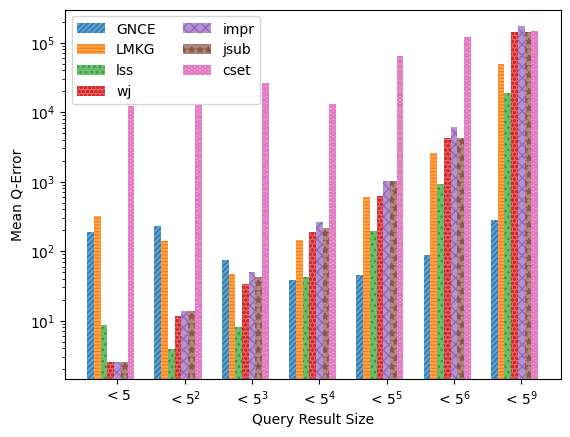

In [126]:
#plt.style.use('grayscale')

bar_cycle = (cycler('hatch', ['//////', '-----', '...','oooo', 'xxx','**', 'OOO', '\\\\']))
styles = bar_cycle()

colormap = mpl.cm.tab10.colors


data = list(barplots_cardinality_data.values())
labels = methods

X_Axis = np.arange(len(data[0]))


for i in range(len(data)):
    hatch_color = list(colormap[i])
    plt.rcParams['hatch.color'] = colormap[i]
    plt.bar(X_Axis - 0.4 + 0.1*i,data[i], 0.1, label=labels[i], color=colormap[i], alpha=0.7, **next(styles))



#plt.ylim(1, 11**5)

plt.yscale("log")

plt.legend(ncol=2)
plt.xticks(X_Axis, ["$< 5$", "$< 5^2$", "< $5^3$", "< $5^4$", "< $5^5$", "< $5^6$", "< $5^9$"])
#plt.xticks(X_Axis, ["$< 5$", "$< 5^2$", "< $5^3$", "< $5^4$", "< $5^5$", "< $5^9$"])

plt.xlabel("Query Result Size")
plt.ylabel("Mean Q-Error")
if save_plots:
    print(f"Saving Cardinality Barplot")
    plt.savefig(f"/home/tim/Datasets/plots/{dataset}_{query_type}_barplot_card.pdf")

#### Boxplots for the methods

In [127]:
# Whether to plot boxplots for MAE or for qError
mode = "q"
# Whether to round the predictions before calculating qError
rounded = True
# Whether to plot over-and underestimation or only the simple qerror
overunder= True

In [128]:
colormap = mpl.cm.tab10.colors

In [129]:
# Creating data for the boxplots
# Creating Barplot Data
boxplot_data = {}
for method in methods:
    boxplot_data[method] = q_error(gts_dict[method], preds_dict[method],
                                   mode=mode, rounded=rounded, overunder=overunder)

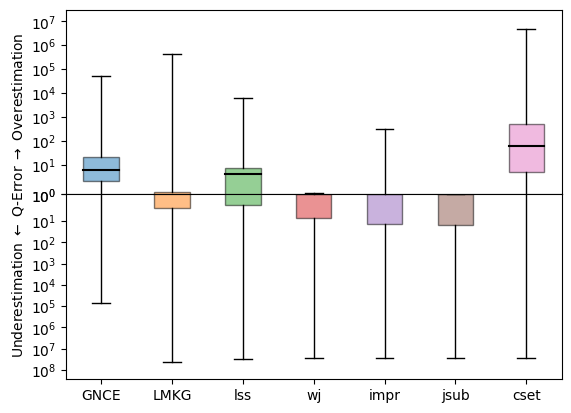

In [130]:
from matplotlib import ticker
import math


data = list(boxplot_data.values())


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.0)

medianprops = dict(color="black",linewidth=1.5)

bplot1 = ax1.boxplot(data, whis=(0,100), sym="", patch_artist=True,medianprops=medianprops)
bplot2 = ax2.boxplot(data, whis=(0,100), sym="", patch_artist=True, medianprops=medianprops)


colors = ['pink', 'lightblue', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colormap):
        patch.set_facecolor(color)
        patch.set_alpha(0.5)

@ticker.FuncFormatter
def major_formatter(x, pos):
    label = "$10^{"+str(int(math.log10(abs(x))))+"}$" if x!=0 else ""
    return label


plt.yscale("symlog")
ax1.set_yscale("symlog")
ax = plt.gca()
ax1.set_ylim(bottom=1)
ax2.set_ylim(top=-1)


ax1.yaxis.set_major_formatter(major_formatter)
ax2.yaxis.set_major_formatter(major_formatter)

plt.xticks(list(range(1, len(methods) + 1)),methods)

ax2.set_ylabel(r'Underestimation $\leftarrow$ Q-Error $\rightarrow$ Overestimation')
ax2.yaxis.set_label_coords(x = -0.08, y= 1)

if save_plots:
    print(f"Saving Boxplot")
    plt.savefig(f"/home/tim/Datasets/plots/{dataset}_{query_type}_boxplot.pdf")


#### Barplots against Query Size

In [131]:
Bins = [2,3,5, 8]

In [132]:
# Creating Barplot Data
barplots_size_data = {}
for method in methods:
    print(method)
    barplots_size_data[method] = barplot_size(gts_dict[method], preds_dict[method], sizes_dict[method][:len(gts_dict[method])])

GNCE
LMKG
lss
wj
impr
jsub
cset


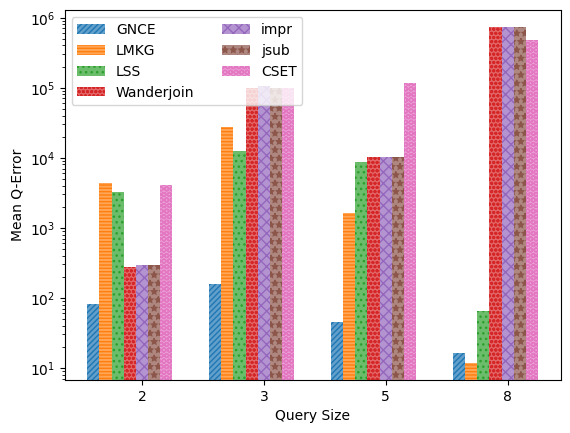

In [133]:

#plt.style.use('grayscale')

bar_cycle = (cycler('hatch', ['//////', '-----', '...','oooo', 'xxx','**', 'OOO', '\\\\']))
styles = bar_cycle()

colormap = mpl.cm.tab10.colors



data = list(barplots_size_data.values())
labels = methods_labels
X_Axis = np.arange(len(data[0]))[:]


for i in range(len(data)):
    hatch_color = list(colormap[i])
    plt.rcParams['hatch.color'] = colormap[i]
    plt.bar(X_Axis - 0.4 + 0.1*i,data[i][:], 0.1, label=labels[i][:], color=colormap[i], alpha=0.7, **next(styles))


plt.yscale("log")
#plt.ylim(0,1000)
plt.legend(ncol=2)
#plt.xticks(X_Axis, ["1", "2", "3", "5"])
plt.xticks(X_Axis, ["2", "3", "5", "8"])

#plt.xticks(X_Axis, ["$< 5$", "$< 5^2$", "< $5^3$", "< $5^4$", "< $5^5$", "< $5^9$"])

plt.xlabel("Query Size")
plt.ylabel("Mean Q-Error")
if save_plots:
    print(f"Saving Cardinality Barplot")
    plt.savefig(f"/home/tim/Datasets/plots/{dataset}_{query_type}_barplot_size.pdf")

# Plotting of total Q Errors per method

## Raw Mean of all Predictions 

In [153]:
for method in methods:
    print(f'Mean Q-Error for {method}')
    print(np.mean(q_error(gts_dict[method], preds_dict[method])))
    print('\n')

Mean Q-Error for GNCE
121.85217820391938


Mean Q-Error for LMKG
15890.684113370542


Mean Q-Error for lss
8622.3963925311


Mean Q-Error for wj
100021.18181966597


Mean Q-Error for impr
102633.01963945258


Mean Q-Error for jsub
100053.82365779368


Mean Q-Error for cset
89538.30623426872




## Mean after averaging over Query Size 

In [154]:
for i in range(len(data)):
    print(f' Q-Error pro tp size for {methods[i]}: ')
    print(data[i])
    print(f'Mean Q-Error for {methods[i]}')
    print(np.mean(data[i]))#
    print('\n')

 Q-Error pro tp size for GNCE: 
[80.94995341926382, 156.88249633997683, 45.82309692997884, 16.26468937695945]
Mean Q-Error for GNCE
74.98005901654473


 Q-Error pro tp size for LMKG: 
[4423.672751537512, 27033.64987509078, 1629.1765434774372, 11.786982750469429]
Mean Q-Error for LMKG
8274.57153821405


 Q-Error pro tp size for lss: 
[3207.700033596838, 12474.928503369514, 8729.824338656163, 64.90818740882042]
Mean Q-Error for lss
6119.340265757834


 Q-Error pro tp size for wj: 
[271.8846013001536, 99675.69422740764, 10273.76923076923, 735276.5172413794]
Mean Q-Error for wj
211374.4663252141


 Q-Error pro tp size for impr: 
[294.08738042038095, 104228.49233379556, 10273.76923076923, 735276.5172413794]
Mean Q-Error for impr
212518.21654659114


 Q-Error pro tp size for jsub: 
[292.6030367451432, 99719.56344682512, 10273.76923076923, 735276.5172413794]
Mean Q-Error for jsub
211390.6132389297


 Q-Error pro tp size for cset: 
[4085.6218170298393, 100003.36845650309, 118076.4852703021, 48

## Mean after averaging over Query Cardinality 

In [155]:
for i in range(len(data)):
    print(f'Mean Q-Error for {methods[i]}')
    print(np.mean(list(barplots_cardinality_data.values())[i]))
    print('\n')

Mean Q-Error for GNCE
134.83213142733067


Mean Q-Error for LMKG
7613.438314027183


Mean Q-Error for lss
2884.6208718265343


Mean Q-Error for wj
20992.878747654886


Mean Q-Error for impr
25569.71678806557


Mean Q-Error for jsub
21089.975825084293


Mean Q-Error for cset
56312.706823083405


